## 패키지

In [1]:
import warnings
warnings.filterwarnings('ignore')
from pandas import DataFrame,read_csv,read_excel,merge,melt,pivot_table
import numpy
from matplotlib import pyplot as plt
import seaborn as sb
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from factor_analyzer.factor_analyzer import calculate_kmo

import numpy as np
import helper
from math import sqrt
from scipy.stats import shapiro, normaltest, ks_2samp
from scipy.stats import bartlett, fligner, levene, chi2_contingency,t
from sklearn.decomposition import PCA #주성분 분석용 패키지
from pca import pca # 주성분 분석 결과를 DataFrame으로 확인할 수 있는 기능을 제공하는 패키지

## 폰트

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.unicode_minus"] = False

### 데이터 불러오기

In [3]:
origin=read_excel('행정동병합테스트2_최종.xlsx')
origin.head()

,시도명,시군구코드,시군구명,행정동코드,읍면동명,면적,서울시전체면적_대비_구성비,인구_수,아동인구,65세이상인구,...,사업체_수,개소_공영_민영,면수_공영_민영,행정동별_공원_산_수,하천및한강여부,사회복지시설_수,공공체육시설_수,문화시설_수,학교_수,보육시설
0,서울특별시,11110,종로구,1111051500,청운효자동,2.57,0.42,11818,612,2154,...,992,668,4592,2,0,5,10,6,8,4
1,서울특별시,11110,종로구,1111053000,사직동,1.23,0.20,9355,488,1808,...,3532,362,12605,3,0,1,8,13,2,11
2,서울특별시,11110,종로구,1111054000,삼청동,1.49,0.25,2642,108,626,...,708,343,2237,1,0,0,2,31,2,3
3,서울특별시,11110,종로구,1111055000,부암동,2.27,0.38,9536,385,1814,...,558,596,3533,1,1,4,5,5,4,3
4,서울특별시,11110,종로구,1111056000,평창동,8.87,1.47,17858,1033,3495,...,747,1617,9390,0,1,11,5,11,4,3


## 데이터 복사

In [4]:
df = origin.copy()

### 데이터 타입 및 이상치, 결측치 확인

In [5]:
df.dtypes

시도명                object
시군구코드               int64
시군구명               object
행정동코드               int64
읍면동명               object
면적                float64
서울시전체면적_대비_구성비    float64
인구_수                int64
아동인구                int64
65세이상인구             int64
장애인_인구              int64
인구밀도              float64
행정동내_지하철역_수         int64
행정동내_의료기관           int64
사업체_수               int64
개소_공영_민영            int64
면수_공영_민영            int64
행정동별_공원_산_수         int64
하천및한강여부             int64
사회복지시설_수            int64
공공체육시설_수            int64
문화시설_수              int64
학교_수                int64
보육시설                int64
dtype: object

In [6]:
df.isna().sum()

시도명               0
시군구코드             0
시군구명              0
행정동코드             0
읍면동명              0
면적                0
서울시전체면적_대비_구성비    0
인구_수              0
아동인구              0
65세이상인구           0
장애인_인구            0
인구밀도              0
행정동내_지하철역_수       0
행정동내_의료기관         0
사업체_수             0
개소_공영_민영          0
면수_공영_민영          0
행정동별_공원_산_수       0
하천및한강여부           0
사회복지시설_수          0
공공체육시설_수          0
문화시설_수            0
학교_수              0
보육시설              0
dtype: int64

> 결측치 없음.

In [7]:
results = []
for column in df.columns:
    zero_count = df.loc[df[column] == 0].shape[0]
    number_count = df.loc[df[column] != 0].shape[0]
    results.append({
        '변수': column,
        '0 값인 수': zero_count,
        '0 값이 아닌 수': number_count
    })
result_df = DataFrame(results)
result_df

,변수,0 값인 수,0 값이 아닌 수
0,시도명,0,426
1,시군구코드,0,426
2,시군구명,0,426
3,행정동코드,0,426
4,읍면동명,0,426
5,면적,0,426
6,서울시전체면적_대비_구성비,0,426
7,인구_수,0,426
8,아동인구,0,426
9,65세이상인구,0,426


> 0값이 0이 아닌 값보다 많은 변수는 존재하지만 실제 조사 데이터이고, 최종적으로는 군집(clustering)을 사용할 계획이므로 정상 값으로 판단.

## 기초통계량 확인


In [8]:
df.describe()

,시군구코드,행정동코드,면적,서울시전체면적_대비_구성비,인구_수,아동인구,65세이상인구,장애인_인구,인구밀도,행정동내_지하철역_수,...,사업체_수,개소_공영_민영,면수_공영_민영,행정동별_공원_산_수,하천및한강여부,사회복지시설_수,공공체육시설_수,문화시설_수,학교_수,보육시설
count,426.000000,4.260000e+02,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,...,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,11433.521127,1.143415e+09,1.420751,0.234836,22697.406103,1247.492958,3914.659624,919.990610,23034.273976,0.741784,...,1907.269953,720.028169,10567.781690,0.302817,0.776995,5.784038,2.978873,1.870892,3.488263,11.061033
std,192.086184,1.920776e+07,1.569773,0.259592,9009.117334,773.747204,1595.815022,490.919804,11427.588087,0.991251,...,1909.412343,527.175416,7181.650766,0.565554,0.416751,4.523958,4.145816,6.832431,2.785019,6.360617
min,11110.000000,1.111052e+09,0.230000,0.040000,73.000000,1.000000,11.000000,3.000000,79.347826,0.000000,...,0.000000,9.000000,193.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11260.000000,1.126066e+09,0.670000,0.110000,16829.750000,717.250000,2844.750000,562.750000,13944.578947,0.000000,...,935.500000,299.000000,6102.500000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,7.000000
50%,11440.000000,1.144064e+09,0.975000,0.160000,22067.000000,1061.500000,3717.000000,817.500000,23208.949275,0.000000,...,1396.000000,619.000000,8621.500000,0.000000,1.000000,5.000000,1.000000,1.000000,3.000000,10.000000
75%,11612.500000,1.161306e+09,1.490000,0.250000,27773.750000,1594.750000,4842.750000,1215.500000,31624.963235,1.000000,...,2085.000000,1066.250000,13132.500000,1.000000,1.000000,8.000000,4.000000,2.000000,5.000000,14.000000
max,11740.000000,1.174070e+09,12.680000,2.100000,55034.000000,6505.000000,8750.000000,3649.000000,56905.000000,7.000000,...,15691.000000,3162.000000,53019.000000,3.000000,1.000000,27.000000,39.000000,108.000000,15.000000,39.000000


In [9]:
df1 = df.copy()
df1 = df1.drop(['시도명','시군구코드','시군구명','행정동코드','읍면동명'],axis=1)
df1.columns

Index(['면적', '서울시전체면적_대비_구성비', '인구_수', '아동인구', '65세이상인구', '장애인_인구', '인구밀도',
       '행정동내_지하철역_수', '행정동내_의료기관', '사업체_수', '개소_공영_민영', '면수_공영_민영',
       '행정동별_공원_산_수', '하천및한강여부', '사회복지시설_수', '공공체육시설_수', '문화시설_수', '학교_수',
       '보육시설'],
      dtype='object')

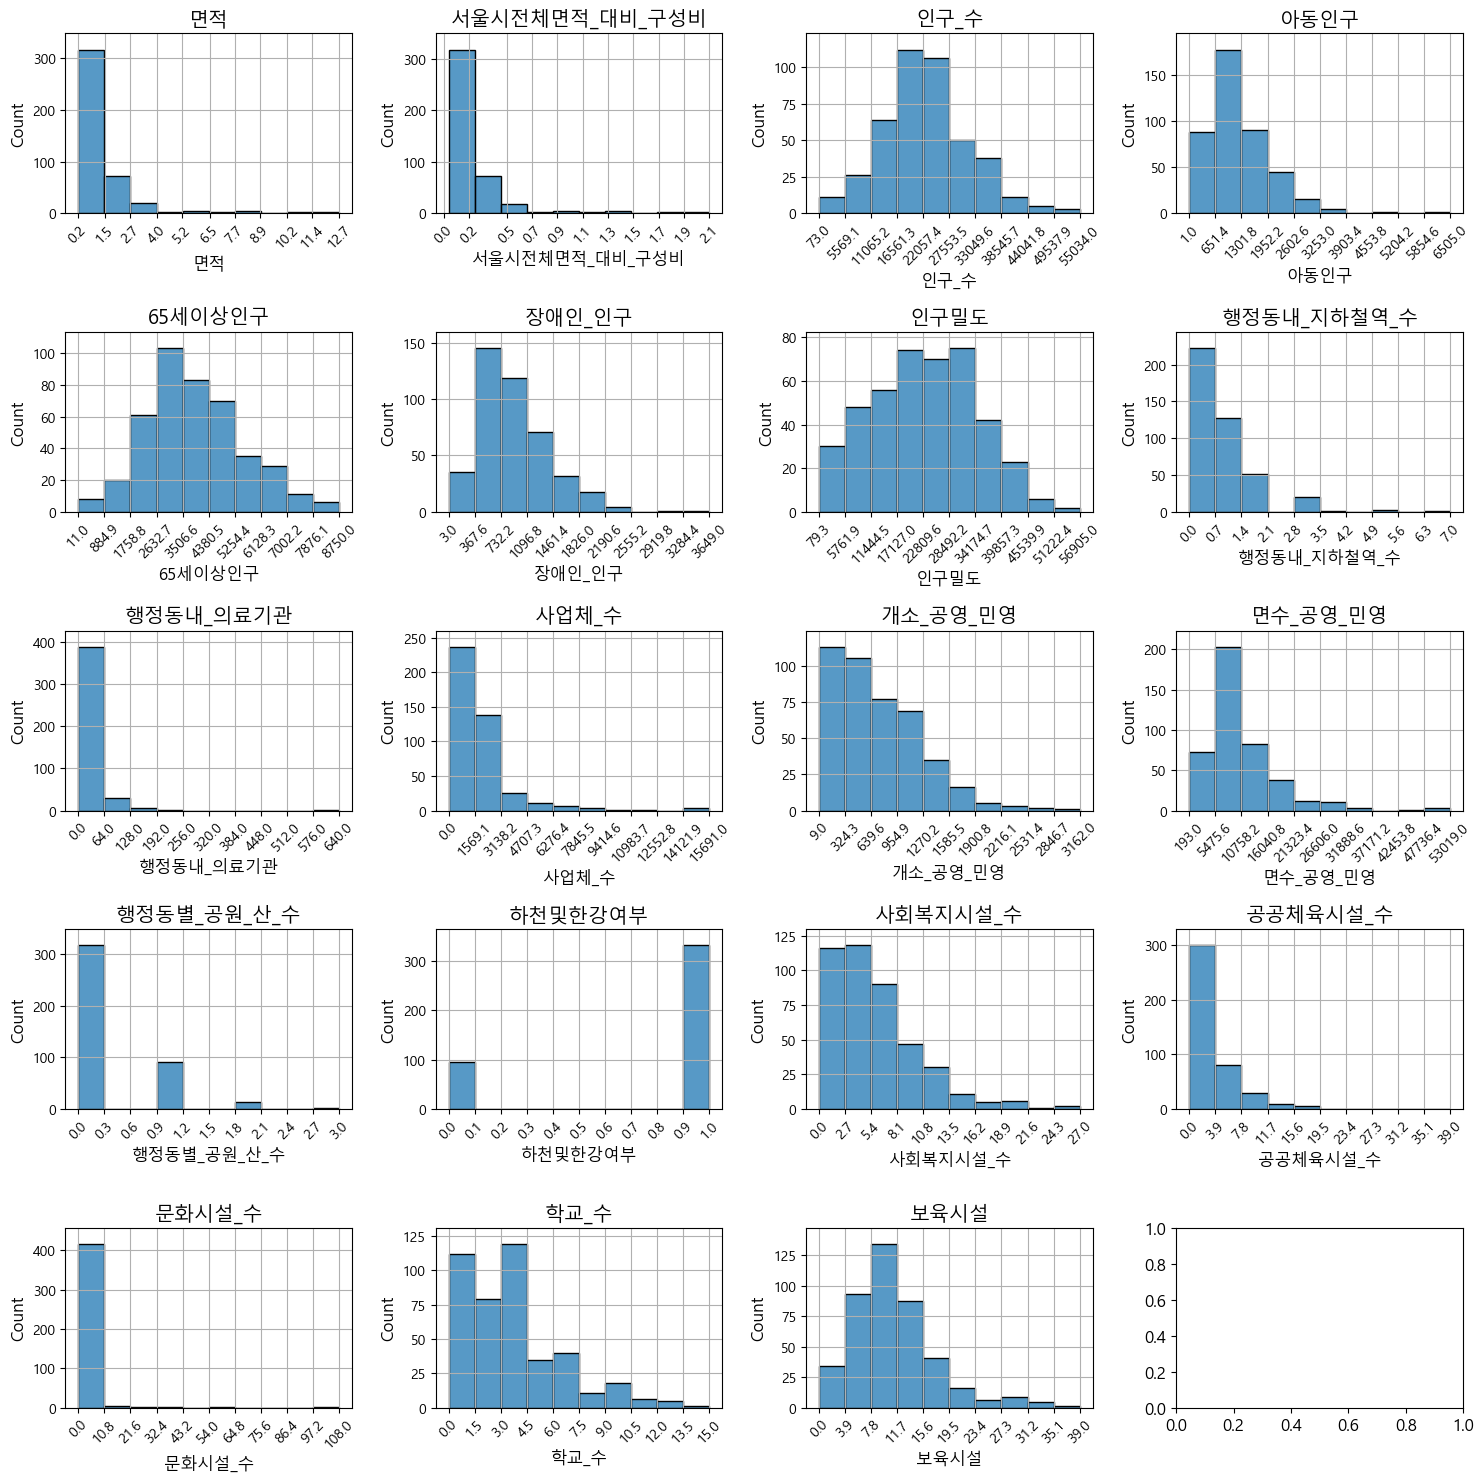

In [10]:
# 이상치 확인 전
# 데이터를 정리해서 볼 수 있도록 도수분포표(히스토그램) 확인

# 히스토그램과 bins(구간) 설정
num_bins = 10 
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))  # 5x3 서브플롯 생성

for ax, column in zip(axes.flat, df1.columns):
    hist, bins = np.histogram(df1[column], bins=num_bins)
    bins2 = np.round(bins, 1)

    sb.histplot(data=df1, x=column, bins=num_bins, kde=False, ax=ax) #확률밀도곡선 미표시(티가 안 남)
    ax.set_title(column)  # 각 subplot의 제목 설정
    ax.set_xticks(bins2)  # x축 눈금 설정
    ax.set_xticklabels(bins2, rotation=45, fontsize=10)  # x축 눈금 라벨(각도 45도), 폰트 설정
    ax.yaxis.set_tick_params(labelsize=10) #y축 폰트 설정

    # y축 범위 설정(여유 범위를 넣어야 가독성이 좋아짐)
    y_max = hist.max() + hist.max() * 0.1  # 최대 도수에 10% 여유를 더한 값으로 y축 최댓값 설정
    ax.set_ylim(0, y_max)  # y축 범위 설정
    ax.grid(True) # 격자 표시

plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

## 이상치 확인

반복문과 sub plot을 이용해 regplot 조회

> 역세권이 중요한 만큼 '행정동내_지하철역_수'를 종속변수로

In [58]:
df1.columns

Index(['면적', '서울시전체면적_대비_구성비', '인구_수', '아동인구', '65세이상인구', '장애인_인구', '인구밀도',
       '행정동내_지하철역_수', '행정동내_의료기관', '사업체_수', '개소', '면수', '행정동별_공원_산_수',
       '하천및한강여부', '사회복지시설_수', '공공체육시설_수', '문화시설_수', '학교_수', '보육시설'],
      dtype='object')

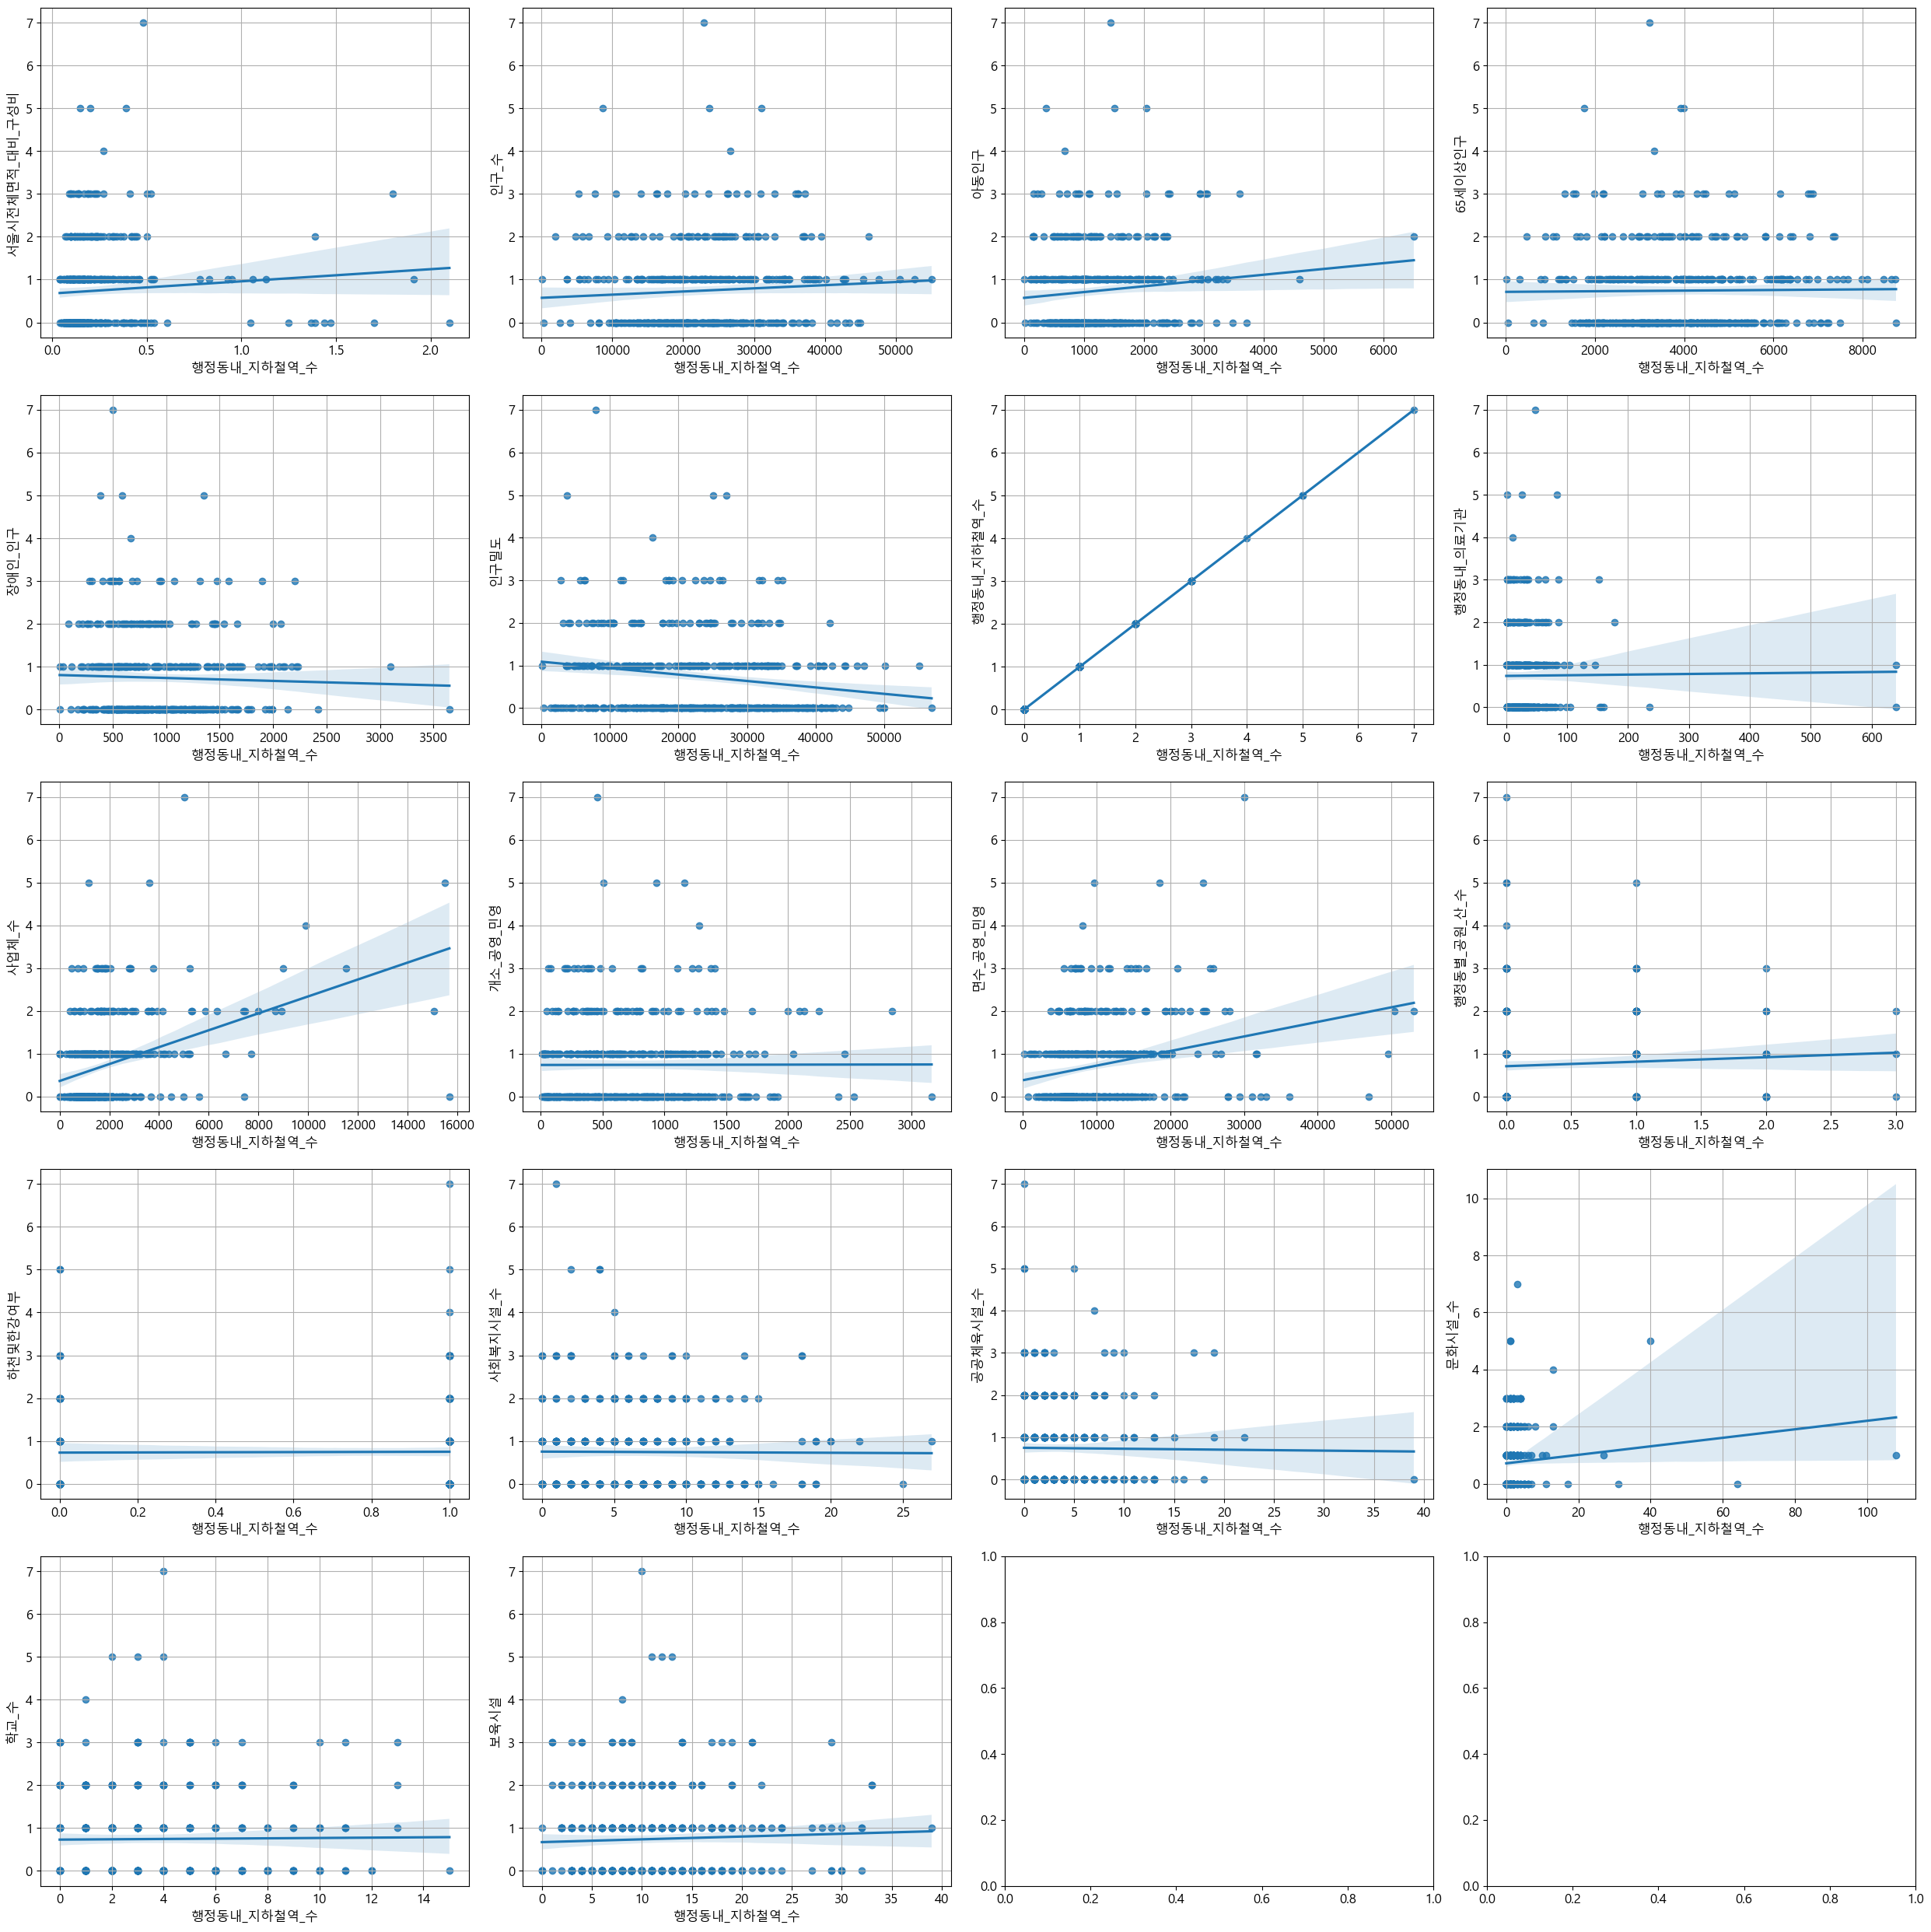

In [12]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리기 때문에 1부터 시작
columns = list(df1.columns)[1:]

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(25, 25))

# 종속변수 설정
dependent_variable = '행정동내_지하철역_수'

for i, c in enumerate(columns):
    row, col = divmod(i, 4)
    sb.regplot(data=df1, y=dependent_variable, x=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    plt.tight_layout() # 그래프 간격 조정
    ax[row, col].grid() # 격자표시

plt.show()
plt.close()

## 반복문과 sub plot을 이용해 boxplot 조회

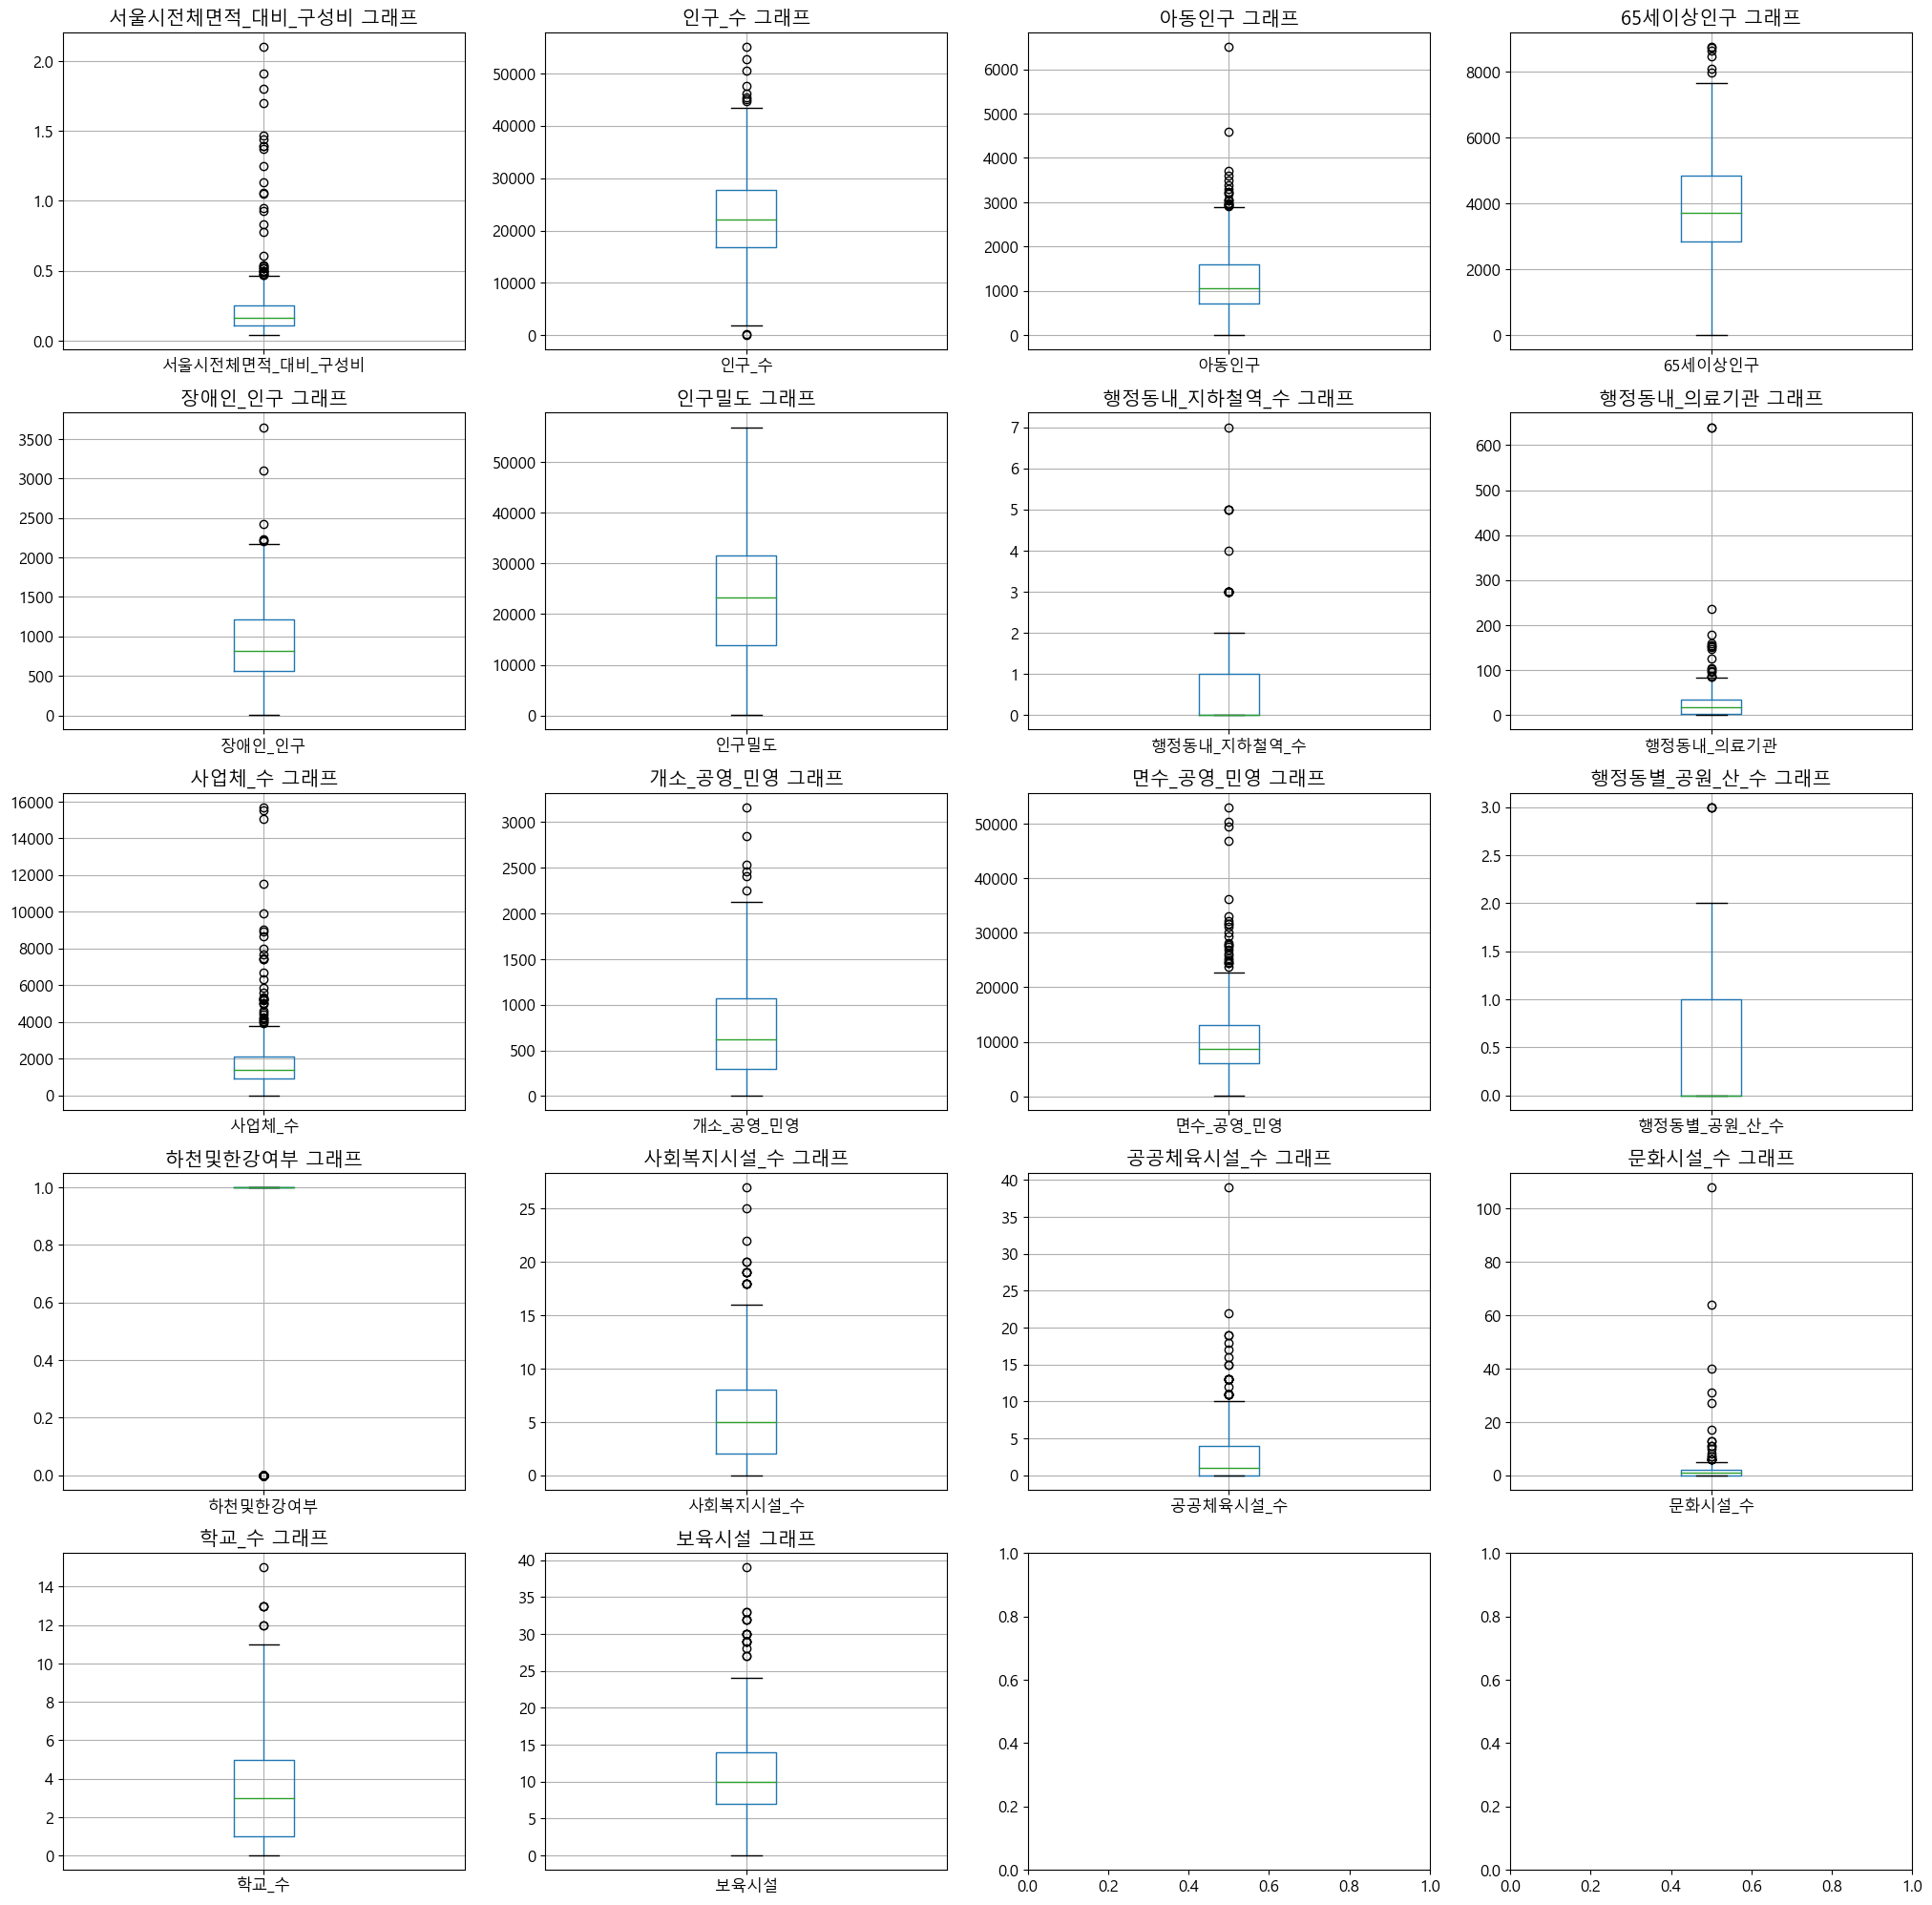

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(25, 25))
for i, c in enumerate(columns):
    row, col = divmod(i, 4)
    df1.boxplot(column=c, ax=ax[row, col])
    ax[row, col].set_title(f"{c} 그래프")
    plt.grid()
plt.show()

> 이상치로 의심되는 값이 존재하지만 실제 조사값인 만큼 사용하기로 결정

# 신뢰구간

In [14]:
df1Col = list(df1.columns)
# df1Col
for cc in df1Col:
    print("%s 신뢰구간95%%"%cc)
    helper.getConfidenceInterval(df1["%s"%cc])

면적 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    1.27126 |
| 상한 |    1.57024 |
+------+------------+
서울시전체면적_대비_구성비 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |   0.210114 |
| 상한 |   0.259557 |
+------+------------+
인구_수 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    21839.5 |
| 상한 |    23555.4 |
+------+------------+
아동인구 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    1173.81 |
| 상한 |    1321.18 |
+------+------------+
65세이상인구 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    3762.69 |
| 상한 |    4066.63 |
+------+------------+
장애인_인구 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    873.239 |
| 상한 |    966.742 |
+------+------------+
인구밀도 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |      21946 |
| 상한 |    24122.5 |
+------+------------+
행정동내_지하철역_수 신뢰구간95%
+------+

### 신뢰구간 계산

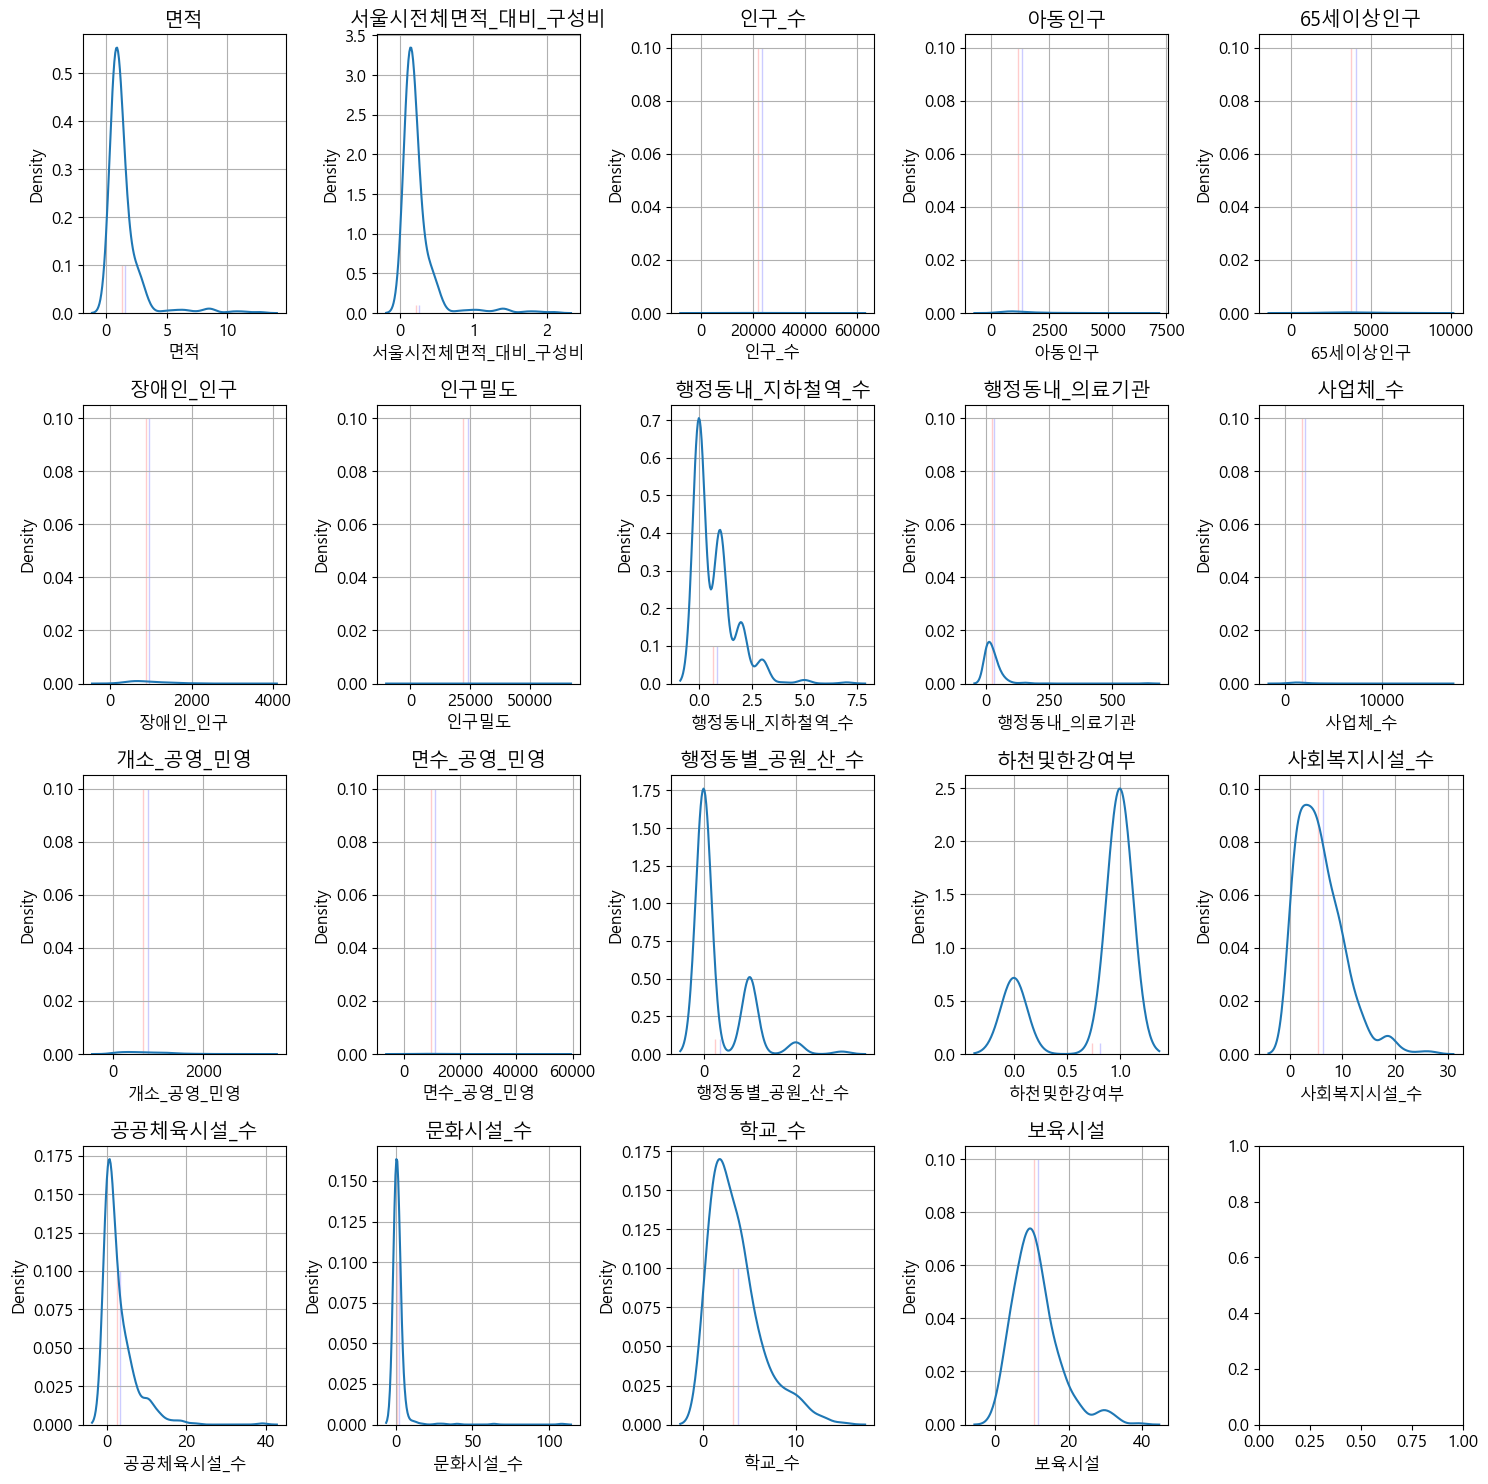

In [16]:
# 변수명 리스트 생성
variables = df1.columns

# 신뢰구간 계산
# 신뢰구간은 95%
confidence_level = 0.95
confidence_intervals = {}  # 각 변수별 신뢰구간을 저장할 딕셔너리

for var in variables:
    sample = df1[var]
    n = len(sample)
    sample_mean = sample.mean()
    sample_std = sample.std(ddof=1)
    std_error = sample_std / sqrt(n)
    
    t_value = t.ppf((1 + confidence_level) / 2, df=n-1)
    margin_of_error = t_value * std_error
    
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error
    
    confidence_intervals[var] = (lower_bound, upper_bound)

# subplot 설정
# num_rows = (len(variables) + 2) // 3  # 3열로 subplot 배치
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15))

# 신뢰구간 시각화
for ax, var in zip(axes.flat, variables):
    cmin, cmax = confidence_intervals[var]  # 하한과 상한
    
    sb.kdeplot(data=df1, x=var, ax=ax)
    sb.lineplot(x=[cmin, cmin], y=[0, 0.1], color='red', ax=ax)
    sb.lineplot(x=[cmax, cmax], y=[0, 0.1], color='blue', ax=ax)
    ax.set_title(f'{var}')
    # ax.set_xlim(x_ranges[var])  # x축 범위 확장
    # ax.set_ylim(y_ranges[var])  # y축 범위 설정
    ax.grid(True)  # 격자 표시
    plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

## 스피어만 상관분석 및 히트맴

In [17]:
helper.spearman_r(df1)

+-------------------------------------------+-------------+--------------+----------+
| fields                                    |   statistic |       pvalue | result   |
|-------------------------------------------+-------------+--------------+----------|
| 면적 vs 서울시전체면적_대비_구성비        |    0.999183 |            0 | True     |
| 서울시전체면적_대비_구성비 vs 인구_수     |     0.43411 |  5.25702e-21 | True     |
| 인구_수 vs 아동인구                       |    0.747458 |  2.50289e-77 | True     |
| 아동인구 vs 65세이상인구                  |    0.574024 |  1.05461e-38 | True     |
| 65세이상인구 vs 장애인_인구               |    0.873669 | 9.48481e-135 | True     |
| 장애인_인구 vs 인구밀도                   |    0.212592 |  9.61581e-06 | True     |
| 인구밀도 vs 행정동내_지하철역_수          |   -0.163557 |  0.000702231 | True     |
| 행정동내_지하철역_수 vs 행정동내_의료기관 |  0.00409005 |     0.932921 | False    |
| 행정동내_의료기관 vs 사업체_수            |  -0.0649149 |     0.181124 | False    |
| 사업체_수 vs 개소_공영_민영               |     0.47361 |  3.33794e-25 | True     

In [18]:
corr = df1.corr(method='spearman')
# corr.head()

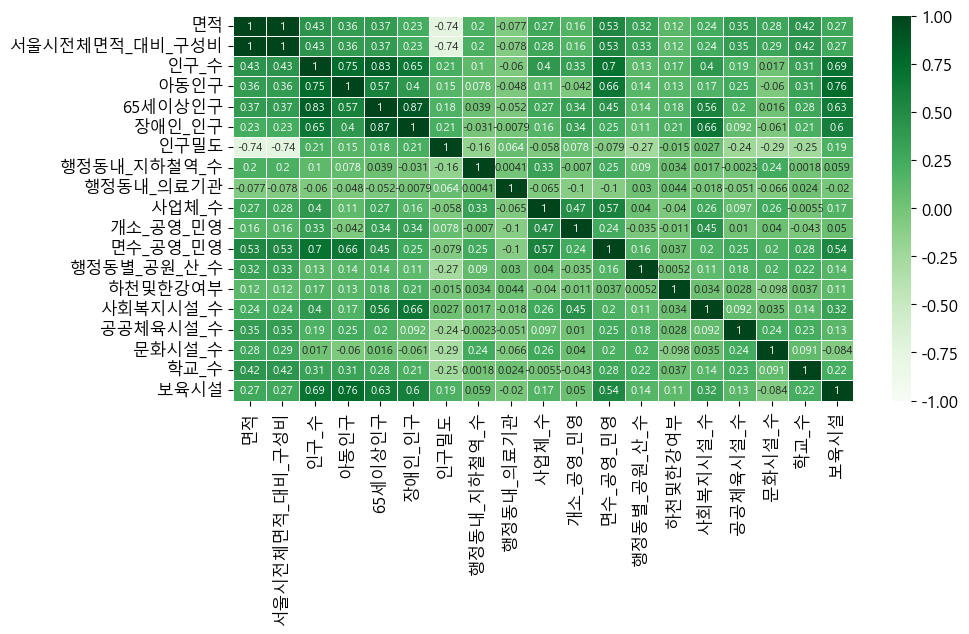

In [19]:
plt.rcParams["figure.figsize"] = (10,5)

sb.heatmap(corr,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상(Greys,Purples,Blues,Greens,Oranges,Reds,OrRd,PuRd,RdPu,BuPu,GnBu,PuBu,YlGnBu,PuBuGn,BuGn,YlGn)
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
           linewidths=.5, #구분선 굵기
           annot_kws={"size": 8}  # 글자 크기 조정
)

plt.show()
plt.close()

> 보육시설은 아동의 이용율이 압도적이며, 고령일 수록 사고 확률을 포함한 다양한 변수로 장애를 얻을 확률이 높은 만큼 상관성이 충분히 존재한다고 판단.

> 역세권의 종속변수는 `행정동내_지하철역_수`로 설정 했을 때 종속변수와 상관성이 높은 `사업체_수`와 `문화시설_수`를 사용해 군집화를 진행해 역세권을 추출

## ols 분석

In [27]:
result = helper.myOls(df1, x=df1.columns, y='행정동내_지하철역_수')
result.summary

## 주성분 분석

In [21]:
cnames = []
dtypes = df1.dtypes

for i, v in enumerate(dtypes):
    if v != 'category':
        print(dtypes.index[i], dtypes[i])
        cnames.append(dtypes.index[i])
        
print(cnames)

면적 float64
서울시전체면적_대비_구성비 float64
인구_수 int64
아동인구 int64
65세이상인구 int64
장애인_인구 int64
인구밀도 float64
행정동내_지하철역_수 int64
행정동내_의료기관 int64
사업체_수 int64
개소_공영_민영 int64
면수_공영_민영 int64
행정동별_공원_산_수 int64
하천및한강여부 int64
사회복지시설_수 int64
공공체육시설_수 int64
문화시설_수 int64
학교_수 int64
보육시설 int64
['면적', '서울시전체면적_대비_구성비', '인구_수', '아동인구', '65세이상인구', '장애인_인구', '인구밀도', '행정동내_지하철역_수', '행정동내_의료기관', '사업체_수', '개소_공영_민영', '면수_공영_민영', '행정동별_공원_산_수', '하천및한강여부', '사회복지시설_수', '공공체육시설_수', '문화시설_수', '학교_수', '보육시설']


In [22]:
# 데이터 정규화-표준화(scaling)
x_train_std_df, y_train_std_df = helper.scalling(df1[cnames], '행정동내_지하철역_수')
x_train_std_df.head()

,면적,서울시전체면적_대비_구성비,인구_수,아동인구,65세이상인구,장애인_인구,인구밀도,행정동내_의료기관,사업체_수,개소_공영_민영,면수_공영_민영,행정동별_공원_산_수,하천및한강여부,사회복지시설_수,공공체육시설_수,문화시설_수,학교_수,보육시설
0,0.732972,0.714129,-1.209019,-0.822284,-1.104595,-0.985005,-1.615171,0.912321,-0.479910,-0.098808,-0.833069,3.004452,-1.866604,-0.173512,1.695537,0.605050,1.621907,-1.111423
1,-0.121658,-0.134352,-1.482731,-0.982732,-1.321667,-1.331701,-1.351705,-0.337982,0.851906,-0.679943,0.284003,4.774710,-1.866604,-1.058733,1.212555,1.630780,-0.535010,-0.009607
2,0.044166,0.058485,-2.228741,-1.474426,-2.063226,-1.651885,-1.862696,-0.474733,-0.628822,-0.716026,-1.161373,1.234194,-1.866604,-1.280038,-0.236389,4.268372,-0.535010,-1.268825
3,0.541637,0.559860,-1.462616,-1.116007,-1.317903,-1.241968,-1.650001,-0.259838,-0.707472,-0.235546,-0.980701,1.234194,0.535732,-0.394817,0.488083,0.458517,0.183962,-1.268825
4,4.751010,4.763698,-0.537799,-0.277539,-0.263284,-0.874878,-1.841656,-0.435661,-0.608373,1.703468,-0.164192,-0.536064,0.535732,1.154320,0.488083,1.337714,0.183962,-1.268825


In [23]:
# # 표준화 결과를 활용하여 주성분 분석 수행
model = pca()
fit = model.fit_transform(x_train_std_df)
topfeat = fit['topfeat']
topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [18] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [18] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[13]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,PC,feature,loading,type
0,PC1,인구_수,0.382019,best
1,PC2,인구밀도,-0.476615,best
2,PC3,사업체_수,0.572786,best
3,PC4,사회복지시설_수,0.468129,best
4,PC5,문화시설_수,0.549370,best
5,PC6,행정동내_의료기관,0.878047,best
6,PC7,하천및한강여부,0.775254,best
7,PC8,학교_수,0.646535,best
8,PC9,공공체육시설_수,-0.544818,best
9,PC10,개소_공영_민영,-0.492770,best


In [24]:
# # 주성분 선정
best = topfeat.query("type=='best'")
best_names = list(set(list(best['feature'])))
best_names

['인구_수',
 '인구밀도',
 '사회복지시설_수',
 '하천및한강여부',
 '공공체육시설_수',
 '학교_수',
 '사업체_수',
 '개소_공영_민영',
 '문화시설_수',
 '행정동내_의료기관']

In [25]:
# target_names 변수에 PCA분석을 통한 best값+종속변수를 결합
target_names = best_names + ['행정동내_지하철역_수']
target_names

['인구_수',
 '인구밀도',
 '사회복지시설_수',
 '하천및한강여부',
 '공공체육시설_수',
 '학교_수',
 '사업체_수',
 '개소_공영_민영',
 '문화시설_수',
 '행정동내_의료기관',
 '행정동내_지하철역_수']

In [26]:
merge_df = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True)
df2 = merge_df.filter(target_names)
df2.head()

,인구_수,인구밀도,사회복지시설_수,하천및한강여부,공공체육시설_수,학교_수,사업체_수,개소_공영_민영,문화시설_수,행정동내_의료기관,행정동내_지하철역_수
0,-1.209019,-1.615171,-0.173512,-1.866604,1.695537,1.621907,-0.479910,-0.098808,0.605050,0.912321,-0.749211
1,-1.482731,-1.351705,-1.058733,-1.866604,1.212555,-0.535010,0.851906,-0.679943,1.630780,-0.337982,1.270813
2,-2.228741,-1.862696,-1.280038,-1.866604,-0.236389,-0.535010,-0.628822,-0.716026,4.268372,-0.474733,-0.749211
3,-1.462616,-1.650001,-0.394817,0.535732,0.488083,0.183962,-0.707472,-0.235546,0.458517,-0.259838,-0.749211
4,-0.537799,-1.841656,1.154320,0.535732,0.488083,0.183962,-0.608373,1.703468,1.337714,-0.435661,-0.749211
